### Load Data

conda activate preprocess_data

In [6]:
import glob
import sys
import os
import re
import numpy as np
import tifffile as tiff
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import random
from send2trash import send2trash

folder_path = r"C:\Users\durrlab-asong\OneDrive - Johns Hopkins\MUSE-BIT\MUSE_BIT_HE_Preprocessing_Code\20251119_MUSE-BIT_preprocessing_training_data"
sys.path.append(folder_path)
from processing_functions import *


## Break up BIT and MUSE images into training patches. 

### Load Data

In [7]:
def compute_optimal_stride(img_shape, patch_size, overlap_percent=0.10):
    """
    Computes the optimal stride (x, y) for given image shape and patch size
    to achieve the desired overlap and ensure full coverage.

    Args:
        img_shape (tuple): (height, width) of the image
        patch_size (int): size of the square patch
        overlap_percent (float): desired fractional overlap (e.g., 0.1 for 10%)

    Returns:
        tuple: (x_stride, y_stride)
    """
    import math

    h, w = img_shape

    # Initial stride from overlap percentage
    stride = int(patch_size * (1 - overlap_percent))
    stride = max(1, stride)

    # Compute number of patches along height and width (round up to ensure coverage)
    n_patches_y = math.ceil((h - patch_size) / stride) + 1
    n_patches_x = math.ceil((w - patch_size) / stride) + 1

    # Recompute stride so that last patch ends exactly at (h - patch_size) and (w - patch_size)
    if n_patches_y > 1:
        y_stride = (h - patch_size) // (n_patches_y - 1)
    else:
        y_stride = 0

    if n_patches_x > 1:
        x_stride = (w - patch_size) // (n_patches_x - 1)
    else:
        x_stride = 0

    return y_stride, x_stride


In [9]:
# Load files
sample_names = ['kidney_normal_1', 'kidney_normal_2', 'kidney_normal_3']

data_base = rf'C:\Users\durrlab-asong\OneDrive - Johns Hopkins\MUSE-BIT\20250701_kidney_JH69436370\normal\MUSE-BIT'


crop_width = 2200
crop_height = 1800
patch_size = 512
number_of_random_patches = 0
step_size_train_x = 256
step_size_train_y = 256
random_indices_or_sequence = True
step_size_test_y, step_size_test_x = compute_optimal_stride((crop_height, crop_width), patch_size, overlap_percent=0.10)

test_train_split_ratio = 0.20  # 25% for test, 75% for train


# training path 
output_path_train = os.path.join(data_base, 'train')
os.makedirs(output_path_train, exist_ok=True)
output_BIT_path_train = os.path.join(output_path_train, 'BIT_patches')
output_MUSE_Blue_path_train = os.path.join(output_path_train, 'MUSE_Blue_patches')
output_MUSE_Green_path_train = os.path.join(output_path_train, 'MUSE_Green_patches')
os.makedirs(output_BIT_path_train, exist_ok=True)
os.makedirs(output_MUSE_Blue_path_train, exist_ok=True)
os.makedirs(output_MUSE_Green_path_train, exist_ok=True)

# testing path 
output_path_test = os.path.join(data_base, 'test')
os.makedirs(output_path_test, exist_ok=True)
output_BIT_path_test = os.path.join(output_path_test, 'BIT_patches')
output_MUSE_Blue_path_test = os.path.join(output_path_test, 'MUSE_Blue_patches')
output_MUSE_Green_path_test = os.path.join(output_path_test, 'MUSE_Green_patches')
os.makedirs(output_BIT_path_test, exist_ok=True)
os.makedirs(output_MUSE_Blue_path_test, exist_ok=True)
os.makedirs(output_MUSE_Green_path_test, exist_ok=True)

In [11]:
for sample in sample_names:
    
    base = os.path.join(data_base, sample)
    root = os.path.join(base, 'in_focus','crop')

    BIT_tif_files = glob.glob(os.path.join(root, '*BIT*.tif'))
    MUSE_Blue_tif_files = glob.glob(os.path.join(root, '*MUSE_blue*.tif'))
    MUSE_Green_tif_files = glob.glob(os.path.join(root, '*MUSE_green*.tif'))

    # Index by (X, Y, Z)
    bit_dict = index_files_by_xyz(BIT_tif_files)
    blue_dict = index_files_by_xyz(MUSE_Blue_tif_files)
    green_dict = index_files_by_xyz(MUSE_Green_tif_files)

    # Find common keys (i.e., matching (X, Y, Z))
    common_keys = set(bit_dict) & set(blue_dict) & set(green_dict)

    # Sort for consistency
    common_keys = sorted(common_keys)

    # Create matched trios
    matched_trios = [(bit_dict[k], blue_dict[k], green_dict[k]) for k in common_keys]
    print(f"Found {len(matched_trios)} matched trios of files.")

    

    if random_indices_or_sequence:
        random_indices = random.sample(range(0, len(matched_trios)+1), int(np.round(test_train_split_ratio*len(matched_trios))))  # 68 is exclusive
    else:
        total_samples = len(matched_trios)
        num_to_sample = int(np.round(test_train_split_ratio * total_samples))

        # Ensure we don't go out of bounds
        max_start_index = total_samples - num_to_sample
        start_index = random.randint(0, max_start_index)

        # Generate consecutive indices
        random_indices = list(range(start_index, start_index + num_to_sample))


    if len(BIT_tif_files) == len(MUSE_Blue_tif_files) and len(BIT_tif_files) == len(MUSE_Green_tif_files):

        for idx, trio in enumerate(matched_trios):
            xyz0 = extract_xyz(trio[0])
            xyz1 = extract_xyz(trio[1])
            xyz2 = extract_xyz(trio[2])

            if xyz0 == xyz1 == xyz2:
                print("✅ All images in the trio have the same X, Y, Z:", xyz0)
            else:
                print("❌ Trio mismatch:")

            print("BIT: ", trio[0])
            print("Blue:", trio[1])
            print("Green:", trio[2])

            seed_val = random.randint(1, 1000)
            BIT_img = tiff.imread(trio[0])
            MUSE_blue_img = tiff.imread(trio[1])
            MUSE_green_img = tiff.imread(trio[2])

            BIT_img = np.asarray(BIT_img) 
            MUSE_blue_img = np.asarray(MUSE_blue_img) 
            MUSE_green_img = np.asarray(MUSE_green_img) 

            ## Median filter the data to reduce granularity? 

            # Add data to Test set
            if idx in random_indices:
                break_image_into_training_patches(
                    'BIT', idx, trio[0], BIT_img, output_BIT_path_test, patch_size, step_size_test_x, step_size_test_y, n_random=0, seed=seed_val)
                break_image_into_training_patches(
                    'MUSE_Blue', idx, trio[1], MUSE_blue_img, output_MUSE_Blue_path_test, patch_size, step_size_test_x, step_size_test_y, n_random=0, seed=seed_val)
                break_image_into_training_patches(
                    'MUSE_Green', idx, trio[2], MUSE_green_img, output_MUSE_Green_path_test, patch_size, step_size_test_x, step_size_test_y, n_random=0, seed=seed_val)
            # Add data to Train set. 
            else:
                break_image_into_training_patches(
                    'BIT', idx, trio[0], BIT_img, output_BIT_path_train, patch_size, step_size_train_x, step_size_train_y, n_random=number_of_random_patches, seed=seed_val)
                break_image_into_training_patches(
                    'MUSE_Blue', idx, trio[1], MUSE_blue_img, output_MUSE_Blue_path_train, patch_size, step_size_train_x, step_size_train_y, n_random=number_of_random_patches, seed=seed_val)
                break_image_into_training_patches(
                    'MUSE_Green', idx, trio[2], MUSE_green_img, output_MUSE_Green_path_train, patch_size, step_size_train_x, step_size_train_y, n_random=number_of_random_patches, seed=seed_val)

    else:
        print("The number of BIT and MUSE images do not match. Please check the input files.")


Found 45 matched trios of files.
✅ All images in the trio have the same X, Y, Z: (0, 0, 2)
BIT:  C:\Users\durrlab-asong\OneDrive - Johns Hopkins\MUSE-BIT\20250701_kidney_JH69436370\normal\MUSE-BIT\kidney_normal_1\in_focus\crop\crop_flat_clahe_BIT_kidney_normal_1_X=0_Y=0_Z=2_expTime=7ms.tif
Blue: C:\Users\durrlab-asong\OneDrive - Johns Hopkins\MUSE-BIT\20250701_kidney_JH69436370\normal\MUSE-BIT\kidney_normal_1\in_focus\crop\crop_flat_clahe_reg_MUSE_blue_kidney_normal_1_X=0_Y=0_Z=2_expTime=2000ms.tif
Green: C:\Users\durrlab-asong\OneDrive - Johns Hopkins\MUSE-BIT\20250701_kidney_JH69436370\normal\MUSE-BIT\kidney_normal_1\in_focus\crop\crop_flat_clahe_MUSE_green_kidney_normal_1_X=0_Y=0_Z=2_expTime=2000ms.tif
Saved 42 patches and metadata to C:\Users\durrlab-asong\OneDrive - Johns Hopkins\MUSE-BIT\20250701_kidney_JH69436370\normal\MUSE-BIT\train\BIT_patches\crop_flat_clahe_BIT_kidney_normal_1_X=0_Y=0_Z=2_expTime=7ms.tif_patches_stitch_metadata.txt
Saved 42 patches and metadata to C:\Users\

### Optionally Expand the dataset

In [4]:
# Parameters for cropping the images. 
crop_parameters = os.path.join(data_base, 'crop_params.txt') 

output_BIT_path_train_expanded = os.path.join(output_path_train, 'BIT_patches_expanded')

os.makedirs(output_BIT_path_train_expanded, exist_ok=True)

top_left, bottom_right = load_crop_parameters(crop_parameters)
print("Top left:", top_left)
print("Bottom right:", bottom_right)


patch_size = 512
step_size_train_x = 480
step_size_train_y = 480
number_of_random_patches = 10
seed_val = 42
idx = 0

Top left: (512, 568)
Bottom right: (2048, 1592)


In [5]:


for sample in sample_names:
    base = os.path.join(data_base, sample)
    BIT_tif_files = glob.glob(os.path.join(base, '*BIT*.tif'))
    for file in BIT_tif_files:
        BIT_img = tiff.imread(file)
        BIT_img = crop_image(BIT_img, top_left, bottom_right)
        BIT_img = flatfield_correct(BIT_img, sigma=50)
        break_image_into_training_patches(
                    'BIT', idx, file, BIT_img, output_BIT_path_train_expanded, patch_size, step_size_train_x, step_size_train_y, n_random=number_of_random_patches, seed=seed_val)
        idx += 1

Saved 6 patches and metadata to C:\Users\durrlab-asong\OneDrive - Johns Hopkins\MUSE-BIT\20250701_kidney_JH69436370\tumor\MUSE-BIT\train\BIT_patches_expanded\BIT_kidney_tumor_1_X=0_Y=0_Z=1_expTime=2ms.tif_patches_stitch_metadata.txt
Saved 6 patches and metadata to C:\Users\durrlab-asong\OneDrive - Johns Hopkins\MUSE-BIT\20250701_kidney_JH69436370\tumor\MUSE-BIT\train\BIT_patches_expanded\BIT_kidney_tumor_1_X=0_Y=0_Z=2_expTime=2ms.tif_patches_stitch_metadata.txt
Saved 6 patches and metadata to C:\Users\durrlab-asong\OneDrive - Johns Hopkins\MUSE-BIT\20250701_kidney_JH69436370\tumor\MUSE-BIT\train\BIT_patches_expanded\BIT_kidney_tumor_1_X=0_Y=0_Z=3_expTime=2ms.tif_patches_stitch_metadata.txt
Saved 6 patches and metadata to C:\Users\durrlab-asong\OneDrive - Johns Hopkins\MUSE-BIT\20250701_kidney_JH69436370\tumor\MUSE-BIT\train\BIT_patches_expanded\BIT_kidney_tumor_1_X=0_Y=0_Z=4_expTime=2ms.tif_patches_stitch_metadata.txt
Saved 6 patches and metadata to C:\Users\durrlab-asong\OneDrive - Jo

In [4]:
n = 2000
move_n_random_images(output_BIT_path_train_expanded, output_BIT_path_train, n)

Moved: BIT_img=674_patch_X=2_Y=5_Z=2_P=11.tif
Moved: BIT_img=96_patch_X=2_Y=6_Z=0_P=11.tif
Moved: BIT_img=96_patch_X=2_Y=6_Z=0_P=3.tif
Moved: BIT_img=582_patch_X=0_Y=0_Z=3_P=10.tif
Moved: BIT_img=175_patch_X=4_Y=7_Z=4_P=12.tif
Moved: BIT_img=490_patch_X=7_Y=6_Z=0_P=11.tif
Moved: BIT_img=266_patch_X=2_Y=1_Z=2_P=4.tif
Moved: BIT_img=386_patch_X=5_Y=1_Z=1_P=9.tif
Moved: BIT_img=778_patch_X=5_Y=4_Z=2_P=9.tif
Moved: BIT_img=311_patch_X=3_Y=2_Z=1_P=2.tif
Moved: BIT_img=139_patch_X=3_Y=7_Z=4_P=9.tif
Moved: BIT_img=446_patch_X=6_Y=5_Z=1_P=11.tif
Moved: BIT_img=740_patch_X=4_Y=4_Z=0_P=8.tif
Moved: BIT_img=701_patch_X=3_Y=3_Z=1_P=10.tif
Moved: BIT_img=540_patch_X=9_Y=0_Z=0_P=12.tif
Moved: BIT_img=605_patch_X=0_Y=6_Z=1_P=10.tif
Moved: BIT_img=491_patch_X=7_Y=6_Z=1_P=2.tif
Moved: BIT_img=383_patch_X=5_Y=0_Z=4_P=1.tif
Moved: BIT_img=479_patch_X=7_Y=3_Z=5_P=12.tif
Moved: BIT_img=320_patch_X=3_Y=4_Z=0_P=7.tif
Moved: BIT_img=697_patch_X=3_Y=2_Z=1_P=8.tif
Moved: BIT_img=389_patch_X=5_Y=1_Z=5_P=9.tif
Mo

### Get mean and std of all training patches

In [12]:
compute_mean_std_and_save(output_BIT_path_train, pattern='*.tif')
compute_mean_std_and_save(output_MUSE_Blue_path_train, pattern='*.tif')
compute_mean_std_and_save(output_MUSE_Green_path_train, pattern='*.tif')

Saved mean and std to: C:\Users\durrlab-asong\OneDrive - Johns Hopkins\MUSE-BIT\20250701_kidney_JH69436370\normal\MUSE-BIT\train\BIT_patches\image_stats.txt
Saved mean and std to: C:\Users\durrlab-asong\OneDrive - Johns Hopkins\MUSE-BIT\20250701_kidney_JH69436370\normal\MUSE-BIT\train\MUSE_Blue_patches\image_stats.txt
Saved mean and std to: C:\Users\durrlab-asong\OneDrive - Johns Hopkins\MUSE-BIT\20250701_kidney_JH69436370\normal\MUSE-BIT\train\MUSE_Green_patches\image_stats.txt


### Normalize patches by Mean and Std of all patches. 

In [43]:
import os
import glob
import tifffile
import numpy as np
def normalize_and_save_uint8_images(
    image_folder,
    output_folder,
    pattern='*.tif',
    z_clip_upper=3.0, 
    z_clip_lower = -3.0
):
    """
    1. Clip values > ±z_clip*std (based on global stats)
    2. Replace those values with the global mean
    3. Normalize by global mean and std
    4. Save image as uint8 TIFF scaled to [0, 255]
    """

    os.makedirs(output_folder, exist_ok=True)
    image_paths = glob.glob(os.path.join(image_folder, pattern))
    if not image_paths:
        raise ValueError(f"No files found in {image_folder} matching {pattern}")
    for path in image_paths:
        img = tifffile.imread(path).astype(np.float32)

        global_mean = np.mean(img)
        global_std = np.std(img)

        # Step 3: Normalize using global mean and std
        img_norm = (img - global_mean) / (global_std + 1e-8)
        norm_img_clipped = np.clip(img_norm, z_clip_lower, z_clip_upper)
        # Step 4: Scale to [0, 255] and convert to uint8
        # Rescale to 0–255 and convert to uint8
        norm_img_scaled = (norm_img_clipped - norm_img_clipped.min()) / (norm_img_clipped.max() - norm_img_clipped.min() + 1e-8)
        norm_img_uint8 = (norm_img_scaled * 255).astype(np.uint8)
        save_path = os.path.join(output_folder, os.path.basename(path))
        tifffile.imwrite(save_path, norm_img_uint8)
    print(f":white_check_mark: Saved {len(image_paths)} normalized images to: {output_folder}")

In [ ]:
z_clip_upper_BIT = 3.0
z_clip_lower_BIT = -3.0

z_clip_upper_MUSE = 10.0
z_clip_lower_MUSE = -10.0

# Train
normalize_and_save_uint8_images(output_BIT_path_train, os.path.join(output_path_train, 'normalized_BIT_train'), pattern='*.tif', z_clip_upper=z_clip_upper_BIT, z_clip_lower = z_clip_lower_BIT)
normalize_and_save_uint8_images(output_MUSE_Blue_path_train, os.path.join(output_path_train, 'normalized_MUSE_Blue_train'), pattern='*.tif', z_clip_upper=z_clip_upper_MUSE, z_clip_lower = z_clip_lower_MUSE)
normalize_and_save_uint8_images(output_MUSE_Green_path_train, os.path.join(output_path_train, 'normalized_MUSE_Green_train'), pattern='*.tif', z_clip_upper=z_clip_upper_MUSE, z_clip_lower = z_clip_lower_MUSE)

# Test
normalize_and_save_uint8_images(output_BIT_path_test, os.path.join(output_path_test, 'normalized_BIT_test'), pattern='*.tif', z_clip_upper=z_clip_upper_BIT, z_clip_lower = z_clip_lower_BIT)
normalize_and_save_uint8_images(output_MUSE_Blue_path_test, os.path.join(output_path_test, 'normalized_MUSE_Blue_test'), pattern='*.tif', z_clip_upper=z_clip_upper_MUSE, z_clip_lower = z_clip_lower_MUSE)
normalize_and_save_uint8_images(output_MUSE_Green_path_test, os.path.join(output_path_test, 'normalized_MUSE_Green_test'), pattern='*.tif', z_clip_upper=z_clip_upper_MUSE, z_clip_lower = z_clip_lower_MUSE)

:white_check_mark: Saved 4200 normalized images to: C:\Users\durrlab-asong\OneDrive - Johns Hopkins\MUSE-BIT\20250701_kidney_JH69436370\normal\MUSE-BIT\train\normalized_MUSE_Blue_train
:white_check_mark: Saved 4200 normalized images to: C:\Users\durrlab-asong\OneDrive - Johns Hopkins\MUSE-BIT\20250701_kidney_JH69436370\normal\MUSE-BIT\train\normalized_MUSE_Green_train
:white_check_mark: Saved 480 normalized images to: C:\Users\durrlab-asong\OneDrive - Johns Hopkins\MUSE-BIT\20250701_kidney_JH69436370\normal\MUSE-BIT\test\normalized_MUSE_Blue_test
:white_check_mark: Saved 480 normalized images to: C:\Users\durrlab-asong\OneDrive - Johns Hopkins\MUSE-BIT\20250701_kidney_JH69436370\normal\MUSE-BIT\test\normalized_MUSE_Green_test


Using BIT image: BIT_img=27_patch_X=3_Y=3_Z=2_P=1.tif with XYZP = (3, 3, 2, 1)


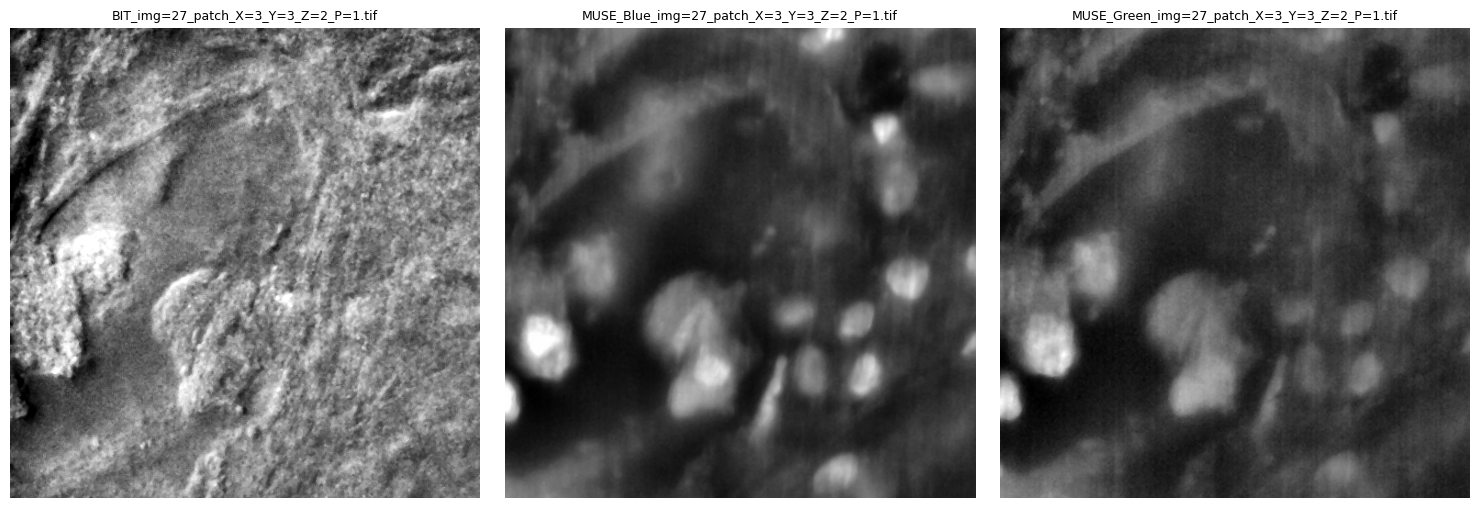

In [50]:
root_bit = os.path.join(data_base, 'test', 'normalized_BIT_test')
root_muse_blue = os.path.join(data_base, 'test', 'normalized_MUSE_Blue_test')
root_muse_green = os.path.join(data_base, 'test', 'normalized_MUSE_Green_test')

# Select BIT image index
bit_idx = random.randint(0, len(os.listdir(root_bit)) - 1)

def extract_xyzp(filename):
    match = re.search(r'_X=(\d+)_Y=(\d+)_Z=(\d+)_P=(\d+)', filename)
    if match:
        return tuple(map(int, match.groups()))
    return None

def find_matching_file(folder, xyzp):
    for fname in os.listdir(folder):
        if extract_xyzp(fname) == xyzp:
            return os.path.join(folder, fname)
    raise FileNotFoundError(f"No file in {folder} with XYZP={xyzp}")

def load_and_prepare_image(path):
    img = tifffile.imread(path)
    if img.ndim > 2:
        img = img[0]  # Take first slice if 3D
    if np.issubdtype(img.dtype, np.floating):
        img = (img - np.min(img)) / (np.max(img) - np.min(img) + 1e-8)
    return img

# Get filename of selected BIT image
bit_files = sorted(os.listdir(root_bit))  # Ensure consistent order
bit_filename = bit_files[bit_idx]
target_xyzp = extract_xyzp(bit_filename)

if not target_xyzp:
    raise ValueError(f"Failed to extract XYZP from: {bit_filename}")

print(f"Using BIT image: {bit_filename} with XYZP = {target_xyzp}")

# Get full paths to matched files
bit_path = os.path.join(root_bit, bit_filename)
blue_path = find_matching_file(root_muse_blue, target_xyzp)
green_path = find_matching_file(root_muse_green, target_xyzp)

# Load and normalize images
images = [load_and_prepare_image(p) for p in [bit_path, blue_path, green_path]]
titles = [os.path.basename(p) for p in [bit_path, blue_path, green_path]]

# Plot side by side
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for ax, img, title in zip(axes, images, titles):
    ax.imshow(img, cmap='gray')
    ax.set_title(title, fontsize=9)
    ax.axis('off')

plt.tight_layout()
plt.show()

### Reconstruct Test Images from Patches so we can reconstruct it later. 

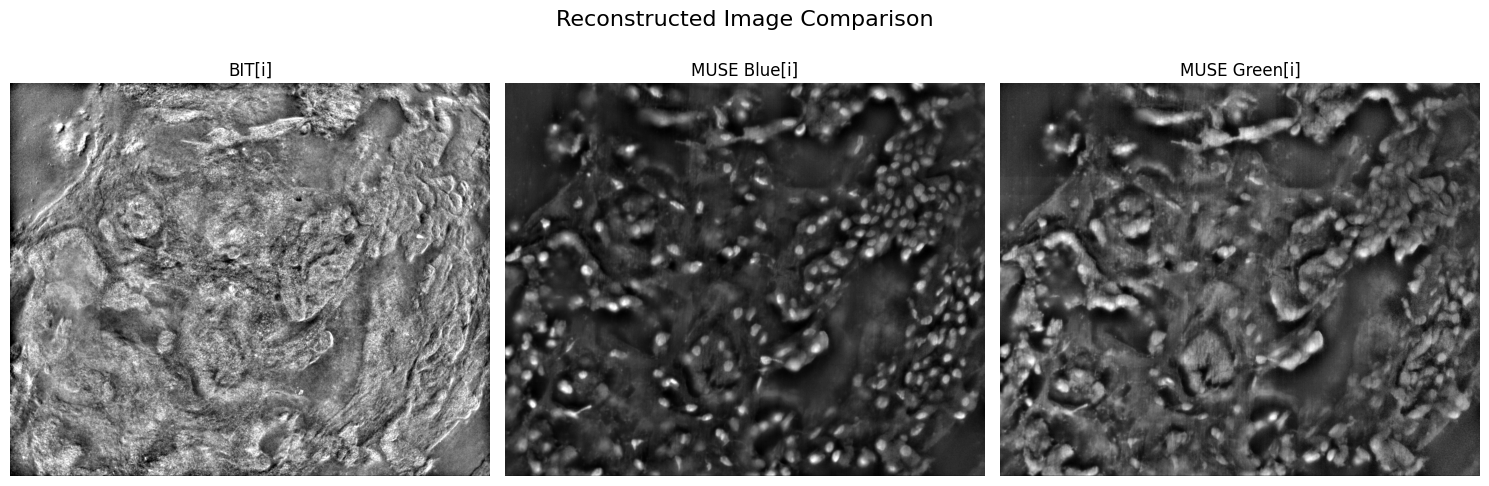

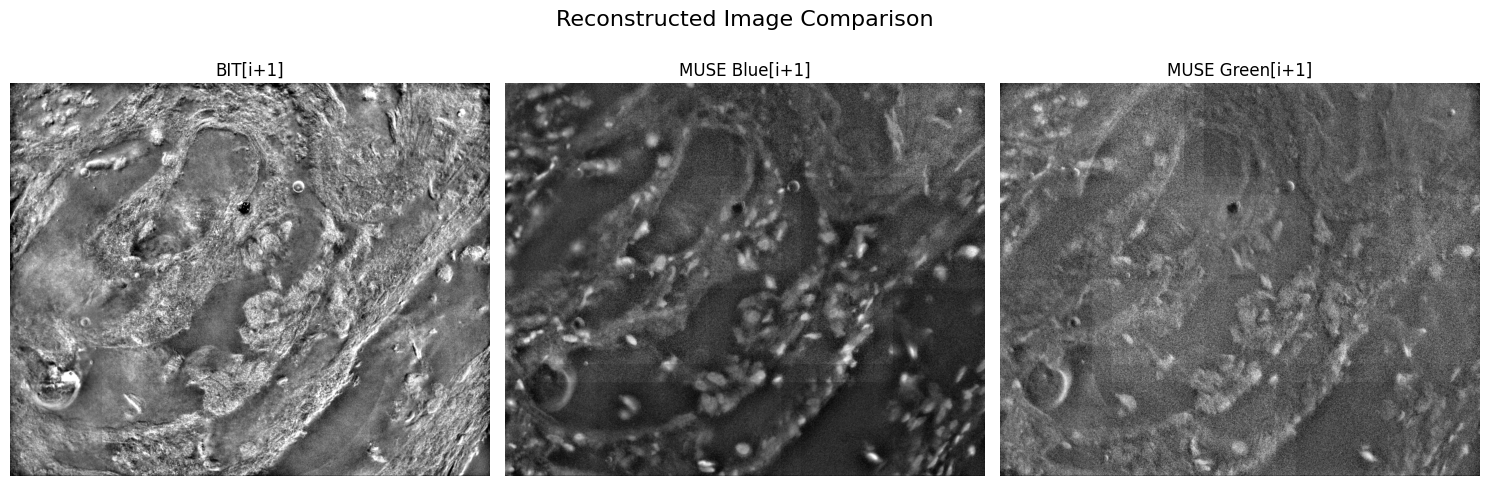

In [52]:
i = 3

BIT_metadata = get_txt_files_sorted_by_xyz(os.path.join(output_path_test, 'BIT_patches'))
MUSE_Blue_metadata = get_txt_files_sorted_by_xyz(os.path.join(output_path_test, 'MUSE_Blue_patches'))
MUSE_Green_metadata = get_txt_files_sorted_by_xyz(os.path.join(output_path_test, 'MUSE_Green_patches'))


reconstructed_BIT_img = reconstruct_image_from_patches(BIT_metadata[i], os.path.join(output_path_test, 'normalized_BIT_test'))
reconstructed_MUSE_Blue_img = reconstruct_image_from_patches(MUSE_Blue_metadata[i], os.path.join(output_path_test, 'normalized_MUSE_Blue_test'))
reconstructed_MUSE_Green_img = reconstruct_image_from_patches(MUSE_Green_metadata[i], os.path.join(output_path_test, 'normalized_MUSE_Green_test'))




show_three_images(reconstructed_BIT_img, reconstructed_MUSE_Blue_img, reconstructed_MUSE_Green_img,
                subtitles=["BIT[i]", "MUSE Blue[i]", "MUSE Green[i]"],
                main_title="Reconstructed Image Comparison")


reconstructed_BIT_img_1 = reconstruct_image_from_patches(BIT_metadata[i+1], os.path.join(output_path_test, 'normalized_BIT_test'))
reconstructed_MUSE_Blue_img_1 = reconstruct_image_from_patches(MUSE_Blue_metadata[i+1], os.path.join(output_path_test, 'normalized_MUSE_Blue_test'))
reconstructed_MUSE_Green_img_1 = reconstruct_image_from_patches(MUSE_Green_metadata[i+1], os.path.join(output_path_test, 'normalized_MUSE_Green_test'))

show_three_images(reconstructed_BIT_img_1, reconstructed_MUSE_Blue_img_1, reconstructed_MUSE_Green_img_1,
                subtitles=["BIT[i+1]", "MUSE Blue[i+1]", "MUSE Green[i+1]"],
                main_title="Reconstructed Image Comparison")



### Remove Saturated Images from the training set. 

In [9]:
print(output_BIT_path_train)

C:\Users\durrlab-asong\OneDrive - Johns Hopkins\MUSE-BIT\20250701_kidney_JH69436370\normal\MUSE-BIT\train\BIT_patches


In [53]:
normalized_BIT_train_path = os.path.join(data_base, 'train', 'normalized_BIT_train')
remove_images_with_saturated_pixels(normalized_BIT_train_path, threshold=0.02)
remove_images_with_black_pixels(normalized_BIT_train_path, threshold=0.02)


# folder_test = os.path.join(root_folder, 'in_focus', 'crop', 'test', 'normalized_BIT_test')
# remove_images_with_saturated_pixels(folder_test, threshold=0.02)
# remove_images_with_black_pixels(folder_test, threshold=0.02)

Removed (saturated): BIT_img=0_patch_X=0_Y=0_Z=1_P=37.tif — 2.24% saturated
Removed (saturated): BIT_img=13_patch_X=1_Y=4_Z=3_P=1.tif — 2.18% saturated
Removed (saturated): BIT_img=18_patch_X=2_Y=0_Z=1_P=2.tif — 2.09% saturated
Removed (saturated): BIT_img=18_patch_X=2_Y=0_Z=1_P=41.tif — 2.02% saturated
Removed (saturated): BIT_img=2_patch_X=0_Y=2_Z=2_P=3.tif — 2.28% saturated
Removed (saturated): BIT_img=51_patch_X=6_Y=3_Z=3_P=28.tif — 2.17% saturated
Removed (saturated): BIT_img=6_patch_X=0_Y=6_Z=0_P=34.tif — 2.31% saturated

Total saturated images removed: 7

Total black images removed: 0


[]